# Leukemia Classification

In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import relevant libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

## Accessing Data Files in Google Drive

In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/Deep Learning and Generative AI/C-NMC_Leukemia/training_data/fold_0"
val_path = "/content/drive/My Drive/Deep Learning and Generative AI/C-NMC_Leukemia/validation_data/val_data"

In [ ]:
normal_imgs = [] # store normal cell image names
cancer_imgs = [] # store cancer cell image names

for file in os.listdir(train_path+"/hem"): # normal cells
  normal_imgs.append(file)
for file in os.listdir(train_path+"/all"): # cancer cells
  cancer_imgs.append(file)

In [ ]:
len(normal_imgs), len(cancer_imgs)

(1130, 2397)

(450, 450, 3)


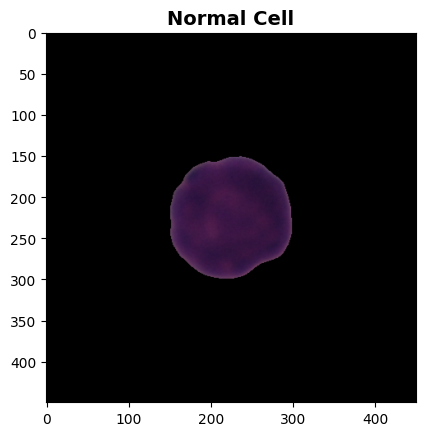

In [ ]:
image_path = os.path.join(train_path+"/hem",normal_imgs[2]) # create the full path to the image
img = mpimg.imread(image_path) # read the image data
print(img.shape) # print the shape of the image data
plt.imshow(img) # display the image data
plt.title("Normal Cell", fontsize=14, fontweight='bold')
plt.show()

(450, 450, 3)


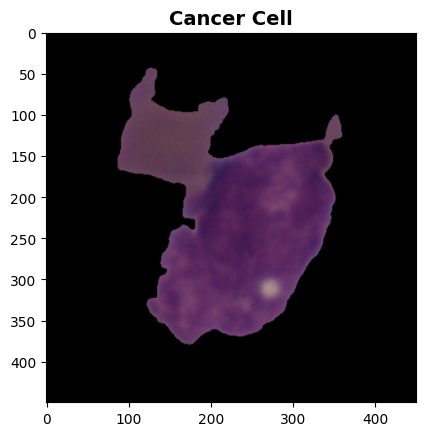

In [ ]:
image_path = os.path.join(train_path+"/all", cancer_imgs[2]) # create the full path to the image
img = mpimg.imread(image_path) # read the image data
print(img.shape) # print the shape of the image data
plt.imshow(img) # display the image data
plt.title("Cancer Cell", fontsize=14, fontweight='bold')
plt.show()

## Image Preprocessing

In [ ]:
dim1 = [] # storing first dimensions of image for analysis
dim2 = [] # storing second dimensions of image for analysis

for image_filename in os.listdir(train_path+'/hem'): # parse through all non-cancer images
    img = mpimg.imread(train_path+'/hem'+'/'+image_filename) # convert image to array
    d1,d2,colors = img.shape # get dimensions of image
    dim1.append(d1) # append to dimension 1 list
    dim2.append(d2) # append to dimension 2 list

for image_filename in os.listdir(val_path+'/all'): # parse through all cancer images
    img = mpimg.imread(val_path+'/all'+'/'+image_filename) # convert image to array
    d1,d2,colors = img.shape # get dimensions of image
    dim1.append(d1) # append to dimension 1 list
    dim2.append(d2) # append to dimension 2 list

In [ ]:
# check for variations in dimensions
np.mean(dim1),np.mean(dim2)

(450.0, 450.0)

In [ ]:
# standard shape of image
image_shape = (226,226,1)

In [ ]:
# import library for image manipulation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# set up generator for image manipulation to add diversity in dataset
image_gen = ImageDataGenerator(rotation_range=20, # rotate 20 degrees
                               width_shift_range=0.10, # shift width by max of 5%
                               height_shift_range=0.10, # shift height by max of 5%
                               rescale=1/255, # rescale image by normalzing
                               shear_range=0.1, # cutting part of image (max 10%)
                               zoom_range=0.1, # zoom by 10% max
                               horizontal_flip=True, # horizontal flip
                               fill_mode='nearest' # fill missing pixels with nearest filled value
                              )

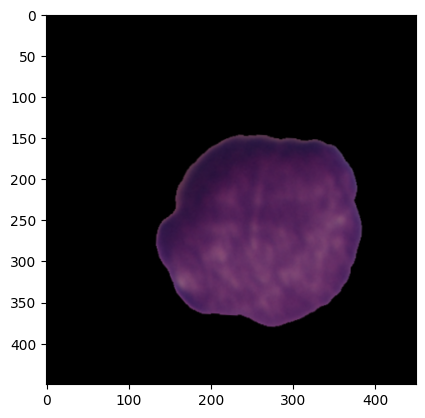

In [ ]:
# rerun this cell as an example of how image is transformed
plt.imshow(image_gen.random_transform(img))

## Convolutional Neural Network Model for Image Classification

In [ ]:
# import relevant libraries from tensor flow for model construction
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()  # make sequential model

# add convolutional layers with pooling layers (max pooling)
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten output
model.add(Flatten())

# add batch normalization
model.add(BatchNormalization())

# add layer of neurons with 'relu' activation
model.add(Dense(128))
model.add(Activation('relu'))

# add dropout layer, rate=0.5
model.add(Dropout(0.6))

# final output neuron for prediction (cancer or not cancer) with 'sigmoid' activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile model with 'ADAM' optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# prints out model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86528)          │       346,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,514,625 (43.92 MB)

 Trainable params: 11,341,569 (43.26 MB)

 Non-trainable params: 173,056 (676.00 KB)

In [ ]:
# early stopping to monitor validation loss for no improvement
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
batch_size = 32 # to train in batches

In [ ]:
# generator to get train images from directory and manipulate
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=(224,224),
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 3527 images belonging to 2 classes.


In [ ]:
# generator to get validation images from directory and manipulate
val_image_gen = image_gen.flow_from_directory(val_path,
                                               target_size=(224,224),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 1867 images belonging to 2 classes.


In [ ]:
train_image_gen.class_indices # check labels of data

{'all': 0, 'hem': 1}

In [ ]:
val_image_gen.class_indices # check labels of data

{'all': 0, 'hem': 1}

In [ ]:
# suppress any warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# fit the model on dataset
results = model.fit(train_image_gen,epochs=20,validation_data=val_image_gen,callbacks=[early_stop])

Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 128s 569ms/step - accuracy: 0.7739 - loss: 0.5035 - val_accuracy: 0.6529 - val_loss: 0.6405
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 96s 431ms/step - accuracy: 0.7899 - loss: 0.4744 - val_accuracy: 0.6551 - val_loss: 0.6503
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 97s 436ms/step - accuracy: 0.7999 - loss: 0.4788 - val_accuracy: 0.6572 - val_loss: 0.6615
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 428ms/step - accuracy: 0.7934 - loss: 0.4775 - val_accuracy: 0.6685 - val_loss: 0.9192
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 96s 431ms/step - accuracy: 0.8008 - loss: 0.4654 - val_accuracy: 0.6743 - val_loss: 0.8509
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.8066 - loss: 0.4632 - val_accuracy: 0.6733 - val_loss: 0.6824


In [ ]:
# save entire CNN model
model.save('cnn_unbalanced_model.keras')

In [ ]:
# save weights separately
model.save_weights('cnn_unbalanced_weights.weights.h5')

In [ ]:
# import relevant library to store model history as json file
import json
with open('cnn_unbalanced_history.json', 'w') as f:
    json.dump(results.history, f)

In [ ]:
# save model architecture to JSON
with open("cnn_unbalanced_architecture.json", "w") as json_file:
    json_file.write(model.to_json())

## Model Evaluation

In [ ]:
# store results as dataframe
losses = pd.DataFrame(model.history.history)

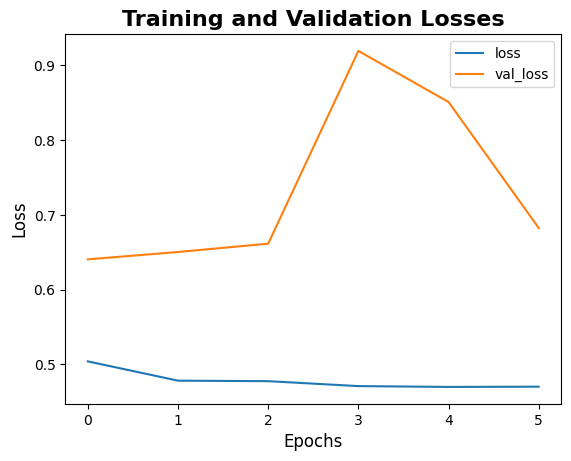

In [ ]:
# plot training and validation losses
ax = losses[['loss', 'val_loss']].plot()

# set title and labels
ax.set_title('Training and Validation Losses', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

plt.show()

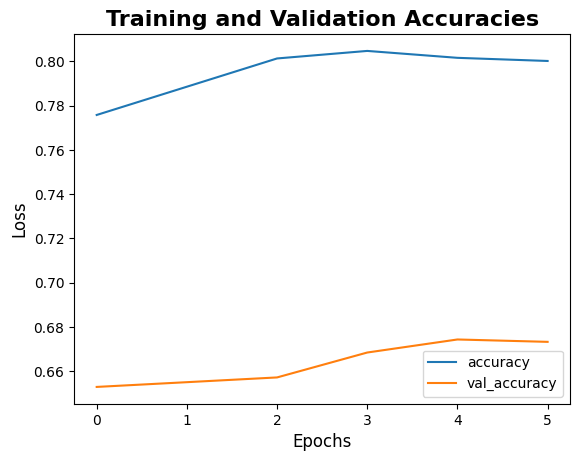

In [ ]:
# plot training and validation accuracies
ax = losses[['accuracy', 'val_accuracy']].plot()

# set title and labels
ax.set_title('Training and Validation Accuracies', fontsize=16, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

plt.show()

In [ ]:
# metrics that were analyzed during fitting
model.metrics_names

['loss', 'compile_metrics']

In [ ]:
# example evaluation on validation dataset to get those metrics
model.evaluate(val_image_gen)

117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.8555 - loss: 0.4002


[0.6922075152397156, 0.6797000765800476]

In [ ]:
# predict on validation dataset
pred_probabilities = model.predict(val_image_gen)

117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step


In [ ]:
# classify predictions in binary method
predictions = pred_probabilities > 0.5
# predictions = (pred > 0.5).astype('int') # another way to do it

In [ ]:
val_image_gen.classes # check labels of data

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# import relevant libraries for classification metrics and quantitative analysis
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# print classification report to understand key metrics
print(classification_report(val_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78      1219
           1       0.55      0.25      0.34       648

    accuracy                           0.67      1867
   macro avg       0.62      0.57      0.56      1867
weighted avg       0.64      0.67      0.63      1867



In [ ]:
# print confusion matrix to investigate accurate predictions
print(confusion_matrix(val_image_gen.classes,predictions))

[[1089  130]
 [ 486  162]]


In [ ]:
# get confusion matrix
cm = confusion_matrix(val_image_gen.classes,predictions)

# extract True Positives, False Negatives, False Positives, True Negatives
TN, FP, FN, TP = cm.ravel()

# calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.2500
Specificity: 0.8934


AUC-ROC Score: 0.57167760


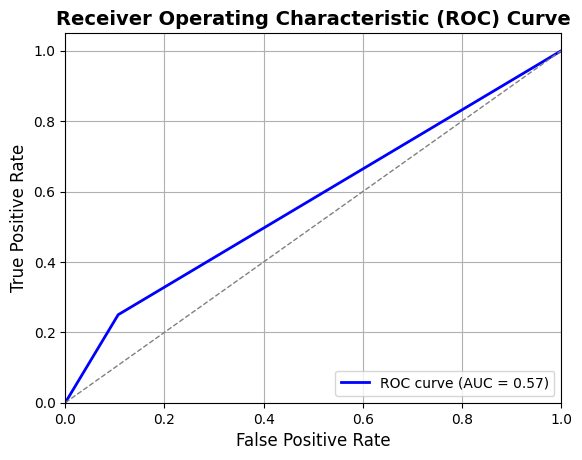

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# calculate AUC-ROC score
auc_roc = roc_auc_score(val_image_gen.classes,predictions)
print(f"AUC-ROC Score: {auc_roc:.8f}")

# compute ROC curve
fpr, tpr, thresholds = roc_curve(val_image_gen.classes,predictions)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14,fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Prediction on Testing Data

In [ ]:
# import relevant library for image analysis
from tensorflow.keras.preprocessing import image

In [ ]:
train_imgs = [] # list to store all training image names

for file in os.listdir(train_path+'/hem'): # parse through training directory and get all normal cell images
    train_imgs.append(file)

In [ ]:
# load an example image - can change number
my_image = image.load_img(os.path.join(train_path+'/hem',train_imgs[3]),target_size=image_shape)

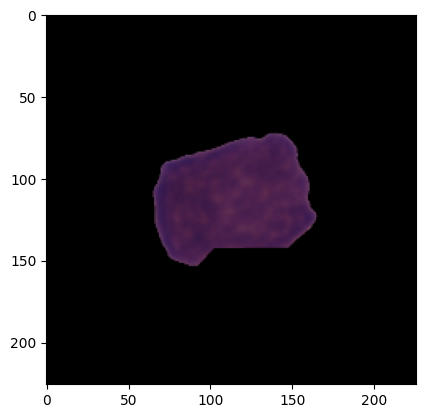

In [ ]:
# plot to see the image of cell
plt.imshow(my_image)

In [ ]:
my_image = image.img_to_array(my_image) # convert from image file to array for prediction

In [ ]:
my_image.shape # check shape of image array

(226, 226, 3)

In [ ]:
my_image = np.expand_dims(my_image, axis=0) # expand dimension to make it compatible as model input

In [ ]:
my_image.shape # recheck shape of image array

(1, 226, 226, 3)

In [ ]:
model.predict(my_image) # make prediction on current selected cell - should be normal

In [ ]:
train_image_gen.class_indices # definition of indices

{'all': 0, 'hem': 1}